In [12]:
import os

# this get our current location in the file system
import inspect
HERE_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))

In [13]:
import numpy as np

In [14]:
import tools
from continuous import ContinuousPlayer
from continuous import ContinuousLearner

In [15]:
def signal_generator_2D(is_target_flashed):
    cov = [[0.1, 0], [0, 0.1]]
    if is_target_flashed:
        mean = [0, 0]
    else:
        mean = [1, 1]
    return np.random.multivariate_normal(mean, cov, 1)[0].tolist()

In [30]:
N_HYPOTHESIS = 10
TARGET = None

for i in range(2, 3):

    seed = i
    tools.set_seed(seed)

    print('{}/{}'.format(i+1, 100))

    player = ContinuousPlayer(N_HYPOTHESIS, signal_generator_2D, TARGET)
    learner = ContinuousLearner(N_HYPOTHESIS, 
                                proba_decision_threshold=0.99, 
                                proba_assigned_to_label_valid=0.9)

    N_FOUND = 1

    run_info = {}
    run_info['steps_to_solved'] = []
    run_info['valid'] = []
    for j in range(100):
        # flash_pattern = learner.get_next_flash_pattern(planning_method='even_random')
        flash_pattern = learner.get_next_flash_pattern(planning_method='even_uncertainty')
        feedback_signal = player.get_feedback_signal(flash_pattern)
        learner.update(flash_pattern, feedback_signal)

        if learner.is_solved():
            true_i_target = player.target_index
            found_i_target = learner.get_solution_index()
            print('{} - {} in {} steps'.format(true_i_target, found_i_target, j+1))
            valid = true_i_target == found_i_target
            run_info['valid'].append(valid)

            run_info['steps_to_solved'].append(j+1)
            if len(run_info['steps_to_solved']) >= N_FOUND:
                break

            # change target and propagate label for next target
            player.update_target_index()
            learner.propagate_labels_from_hypothesis(found_i_target)

Setting seed to 2
3/100
8 - 8 in 14 steps


In [31]:
import matplotlib
import matplotlib.pyplot as plt
plt.ion()

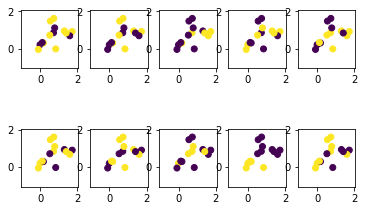

In [32]:
##
fig = plt.figure()
X = np.array(learner.signal_history)
for i_hyp in range(N_HYPOTHESIS):
    y = learner.hypothesis_labels[i_hyp]
    ax = plt.subplot(2, 5, i_hyp+1)
    ax.scatter(X[:,0], X[:,1], c=y)

    delta = 0.05
    ax.set_aspect('equal')
    ax.set_xlim([- 1 - delta, 2 + delta])
    ax.set_ylim([- 1 - delta, 2 + delta])

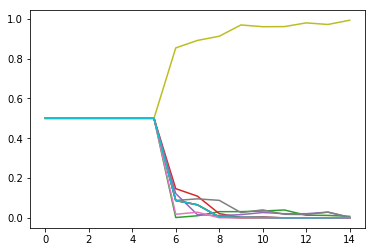

In [33]:
#
fig = plt.figure()
plt.plot(learner.hypothesis_probability_history)

In [29]:
learner.get_logs()

{'learner_type': 'continuous',
 'n_hypothesis': 10,
 'use_leave_one_out': True,
 'proba_decision_threshold': 0.9,
 'proba_assigned_to_label_valid': 0.9,
 'hypothesis_probability_history': [[0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.08768749779869063,
   0.08768749779869063,
   0.0019589737525676303,
   0.14680634883685417,
   0.12225488478240144,
   0.08770033011780248,
   0.018316054994028382,
   0.08770033011780248,
   0.8531936511631458,
   0.08770033011780248],
  [0.0655881413841728,
   0.0655881413841728,
   0.010787779214507132,
   0.1091939401976945,
   0.01614328324360172,
   0.06566377999352326,
   0.028588108440171896,
   0.09567723925778249,
   0.8908060598023058,
   0.

In [11]:
# code below is used to test the plotting of clasifer map for web display
# adding openvault_web/server directory to path
import sys
openvault_web_path = os.path.join(HERE_PATH, '..', 'openvault_web', 'server')
sys.path.append(openvault_web_path)
import web_tools

solution = learner.get_solution_index()
clf = learner.hypothesis_classifier_infos[solution]
y_img = web_tools.generate_map_from_classifier(clf, bounds=(-5, 5))

web_tools.save_map_to_file(y_img, 'classifier_boundaries.png', fig_width_inches=5)

signal_scaled, scaler = web_tools.scale_data_to_view_windows(learner.signal_history)

map_grid = web_tools.generate_map_from_classifier(clf, scaler=scaler)

web_tools.save_map_to_file(map_grid, 'classifier_boundaries_scaled.png', fig_width_inches=5)